In [5]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.ndimage.filters import convolve

import math
import cv2

In [2]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    #filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    #filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels


    return convolved

In [3]:
def minimum_seam(img):
    r, c = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [4]:
def carve_column(img):
    r, c = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]
    plt.plot(np.argwhere(mask==False)[:,[0]] , np.argwhere(mask==False)[:,[1]], c='red')

    # Since the image has 3 channels, we convert our
    # mask to 3D
    #mask = np.stack([mask] * 3, axis=2)

    plt.imshow(image1, origin='upper')
    
    
    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape(r, c - 1)
    
    

    return img

In [10]:
image1 = cv2.imread('image2.jpg', 0)

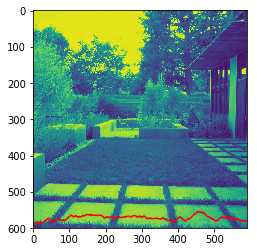

In [11]:
after_img = carve_column(image1)

In [7]:
def crop_c(img, scale_c):
    r, c  = img.shape
    new_c = int(scale_c * c)

    for i in range(c - new_c): # use range if you don't want to use tqdm
        img = carve_column(img)

    return img

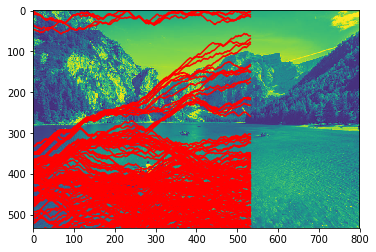

In [8]:
final_image = crop_c(image1, 0.8)

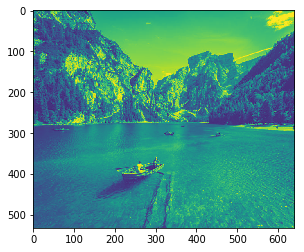

In [9]:
plt.imshow(final_image)

In [2]:
def peak_local_max(image, min_distance=10, threshold=0.1):
    """Return coordinates of peaks in an image.
    Peaks are the local maxima in a region of `2 * min_distance + 1`
    (i.e. peaks are separated by at least `min_distance`).
    Parameters
    ----------
    image: ndarray of floats
        Input image.
    min_distance: int, optional
        Minimum number of pixels separating peaks and image boundary.
    threshold: float, optional
        Candidate peaks are calculated as `max(image) * threshold`.
    Returns
    -------
    coordinates : (N, 2) array
        (row, column) coordinates of peaks.
    """
    image = image.copy()
    # Non maximum filter
    size = 2 * min_distance + 1
    image_max = ndimage.maximum_filter(image, size=size, mode='constant')
    mask = (image == image_max)
    image *= mask

    # Remove the image borders
    image[:min_distance] = 0
    image[-min_distance:] = 0
    image[:, :min_distance] = 0
    image[:, -min_distance:] = 0

    # find top corner candidates above a threshold
    corner_threshold = np.max(image.ravel()) * threshold
    image_t = (image >= corner_threshold) * 1

    # get coordinates of peaks
    coordinates = np.transpose(image_t.nonzero())

    return coordinates

In [84]:


def _compute_harris_response(image, eps=1e-6, gaussian_deviation=1):
    """Compute the Harris corner detector response function
    for each pixel in the image
    Parameters
    ----------
    image : ndarray of floats
        Input image.
    eps : float, optional
        Normalisation factor.
    gaussian_deviation : integer, optional
        Standard deviation used for the Gaussian kernel.
    Returns
    --------
    image : (M, N) ndarray
        Harris image response
    """
    if len(image.shape) == 3:
        image = image.mean(axis=2)
    print(image.shape)

    # derivatives
    image = ndimage.gaussian_filter(image, gaussian_deviation)
    imx = ndimage.sobel(image, axis=0, mode='constant')
    imy = ndimage.sobel(image, axis=1, mode='constant')

    Wxx = ndimage.gaussian_filter(imx * imx, 1, mode='constant')
    Wxy = ndimage.gaussian_filter(imx * imy, 1, mode='constant')
    Wyy = ndimage.gaussian_filter(imy * imy, 1, mode='constant')

    # determinant and trace
    Wdet = Wxx * Wyy - Wxy ** 2
    Wtr = Wxx + Wyy
    # Alternate formula for Harris response.
    # Alison Noble, "Descriptions of Image Surfaces", PhD thesis (1989)
    harris = Wdet / (Wtr + eps)

    return harris


def harris(image, min_distance=10, threshold=0.1, eps=1e-6,
           gaussian_deviation=1):
    """Return corners from a Harris response image
    Parameters
    ----------
    image : ndarray of floats
        Input image.
    min_distance : int, optional
        Minimum number of pixels separating interest points and image boundary.
    threshold : float, optional
        Relative threshold impacting the number of interest points.
    eps : float, optional
        Normalisation factor.
    gaussian_deviation : integer, optional
        Standard deviation used for the Gaussian kernel.
    Returns
    -------
    coordinates : (N, 2) array
        (row, column) coordinates of interest points.
    """
    harrisim = _compute_harris_response(image, eps=eps,
                    gaussian_deviation=gaussian_deviation)
    coordinates = peak_local_max(harrisim, min_distance=min_distance,
                                        threshold=threshold)
    return coordinates

In [88]:
image4 = cv2.imread('building.jpg', 1)

In [89]:
coordinates = harris(image4, 10, 0.1)

(751, 1024)


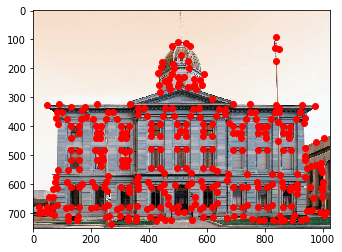

In [90]:
plt.imshow(image4)
    
plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r')
    
plt.show()